In [2]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import pendulum
import seaborn as sns

In [3]:
CHARSET = 'utf-8'
TIMEZONE = 'America/Sao_Paulo'
STR_SUB_DATE = '2025-07-11T00:00:00-03:00'
END_SUB_DATE = '2025-07-31T00:00:00-03:00'
YEAR = '2025'

print('Observação!')
print(f'Os dados foram obtidos via scrapping da API da Twitch e obtenção manual dos clips na KICK em 01 jan. 2026, relativo a clips feitos entre 01 jan. 2025 e 31 dez. 2025. A Subathon ocorreu entre os dias {pendulum.parse(STR_SUB_DATE).format('DD/MM')} e {pendulum.parse(END_SUB_DATE).format('DD/MM')} de {YEAR}.')
print('')

print('Nota!')
print(f'- Os dados aqui são apenas referente ao scrapping da Twitch.')

# Configurações visuais globais
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Observação!
Os dados foram obtidos via scrapping da API da Twitch e obtenção manual dos clips na KICK em 01 jan. 2026, relativo a clips feitos entre 01 jan. 2025 e 31 dez. 2025. A Subathon ocorreu entre os dias 11/07 e 31/07 de 2025.

Nota!
- Os dados aqui são apenas referente ao scrapping da Twitch.


In [4]:
# Importando o arquivo do scrapping da Twitch
twitch_path = 'C:/projects/battle-tube-2-analysis/data/scrapping-all.json'
twitch_data = pd.read_json(twitch_path, encoding=CHARSET)
twitch_data['platform'] = 'Twitch'

# Importando o arquivo montado com dados dos clips da Kick
kick_path = 'C:/projects/battle-tube-2-analysis/data/kick-clips.json'
kick_data = pd.read_json(kick_path, encoding=CHARSET)
kick_data['platform'] = 'Kick'

# Juntando os dados
all_data = pd.concat([twitch_data, kick_data], ignore_index=True)

# Tratar dados NaN e normalizá-los
# Preenchendo valores nulos em view_count com 0
all_data['view_count'] = all_data['view_count'].fillna(0)

# Convertendo created_at para datetime e ajustando timezone
# Assumindo que os dados originais estão em UTC
all_data['created_at'] = pd.to_datetime(all_data['created_at'])
if all_data['created_at'].dt.tz is None:
    all_data['created_at'] = all_data['created_at'].dt.tz_localize('UTC')
all_data['created_at'] = all_data['created_at'].dt.tz_convert(TIMEZONE)

# Normalizando titulos para string
all_data['title'] = all_data['title'].astype(str)

# print(all_data.info())
# print(all_data.head())


In [5]:
# Dados de dias com mais clips
daily_clips = all_data.groupby(all_data['created_at'].dt.date).size().sort_values(ascending=False)
print('Dias com mais clips:')
print(daily_clips.head(10))

Dias com mais clips:
created_at
2025-07-12    22
2025-12-11    20
2025-01-13    17
2025-01-26    16
2025-08-23    16
2025-10-29    15
2025-06-24    13
2025-07-20    12
2025-01-15    12
2025-01-06    12
dtype: int64


In [6]:
# Maiores clippers
top_clippers = all_data['creator_name'].value_counts().sort_values(ascending=False)
print('Maiores clippers:')
print(top_clippers.head(10))

Maiores clippers:
creator_name
rafuxo_2ne1           69
eskimozin             45
odraudinho            44
pantaloreza__         23
kkkkkinho             21
pestei                15
tinhaqueserotomtom    15
Benja_Lenja           14
ratoacucar            12
littlemots            11
Name: count, dtype: int64


In [7]:
# Mais vistos
most_viewed = all_data.sort_values(by='view_count', ascending=False)
print('Clips mais vistos:')
print(most_viewed[['title', 'view_count', 'platform']].head(10))


Clips mais vistos:
                                      title  view_count platform
153  vamo fazer uma sacanagem com esse sapo      1278.0   Twitch
432               nathan descobre as regras       832.0   Twitch
459                    ele nunca faria isso       571.0   Twitch
122                                    caiu       546.0   Twitch
671                             i saw grass       335.0   Twitch
371                           cereaw: BOO!!       316.0   Twitch
103                                um pato?       281.0   Twitch
112                                me prove       279.0   Twitch
699                         W modo restrito       248.0   Twitch
577                                 W queda       205.0   Twitch


In [8]:
# Dias da semana com mais clips
# 0 = Segunda, 6 = Domingo
weekday_clips = all_data['created_at'].dt.day_name().value_counts()
print('Dias da semana com mais clips:')
print(weekday_clips)


Dias da semana com mais clips:
created_at
Saturday     150
Monday       135
Friday       135
Wednesday    120
Sunday        88
Thursday      68
Tuesday       64
Name: count, dtype: int64


Horários com mais clips:
hour
21.0    140
20.0    111
22.0    103
23.0     81
19.0     63
0.0      42
18.0     33
14.0     28
15.0     25
17.0     22
Name: count, dtype: int64

Períodos com mais clips:
period
Noite    656
Tarde    113
Manhã     38
Name: count, dtype: int64


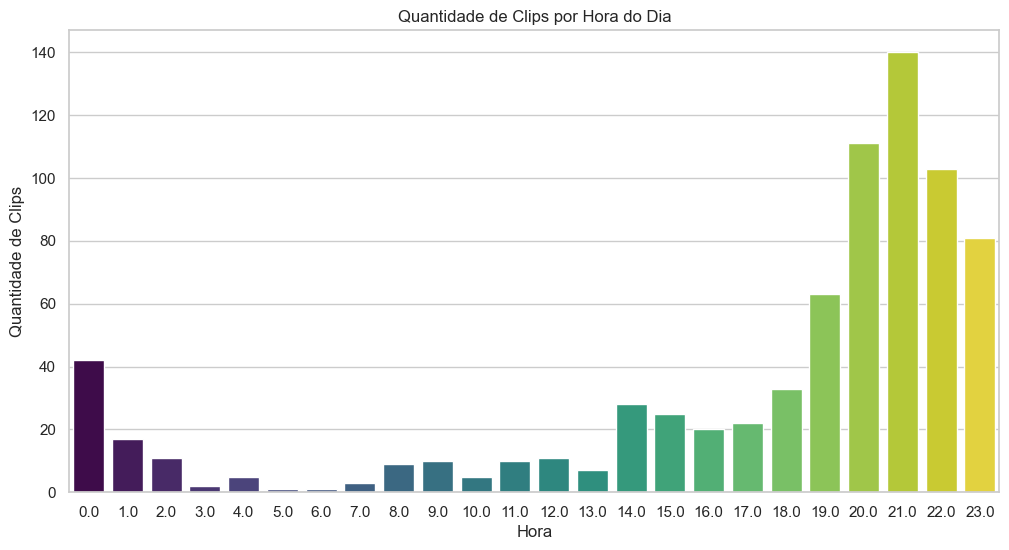

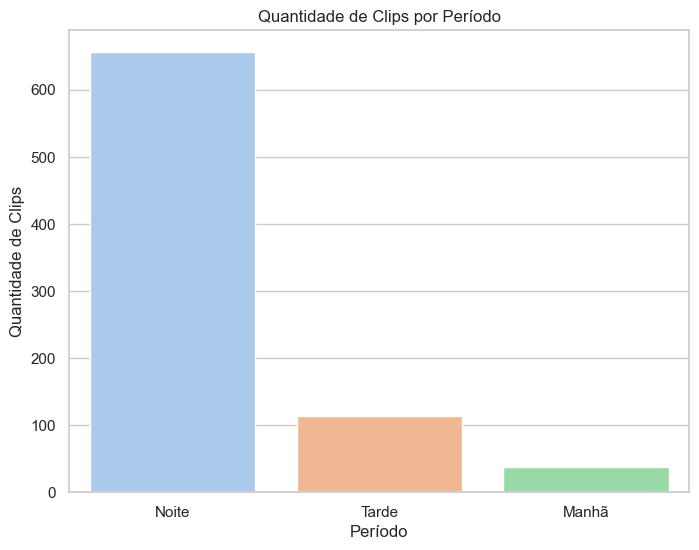

In [9]:
# Horário em que mais clips são feitos e o período (manhã, tarde, noite)
def get_period(hour):
    if 6 <= hour < 12:
        return 'Manhã'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noite'


all_data['hour'] = all_data['created_at'].dt.hour
all_data['period'] = all_data['hour'].apply(get_period)

hourly_clips = all_data['hour'].value_counts().sort_index()
period_clips = all_data['period'].value_counts()

print('Horários com mais clips:')
print(hourly_clips.sort_values(ascending=False).head(10))
print('\nPeríodos com mais clips:')
print(period_clips)

# Gráfico comparando por horários
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_clips.index, y=hourly_clips.values, palette='viridis', hue=hourly_clips.index, legend=False)
plt.title('Quantidade de Clips por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Quantidade de Clips')
plt.show()

# Gráfico por período (manhã - tarde - noite)
plt.figure(figsize=(8, 6))
sns.barplot(x=period_clips.index, y=period_clips.values, palette='pastel', hue=period_clips.index, legend=False)
plt.title('Quantidade de Clips por Período')
plt.xlabel('Período')
plt.ylabel('Quantidade de Clips')
plt.show()


Acumulado de visualizações por clippers:
creator_name
odraudinho     2658.0
Nanachansz      913.0
rafuxo_2ne1     878.0
pestei          790.0
bianca_call     682.0
ratoacucar      463.0
littlemots      416.0
eskimozin       398.0
kkkkkinho       348.0
MissEeevee      335.0
Name: view_count, dtype: float64


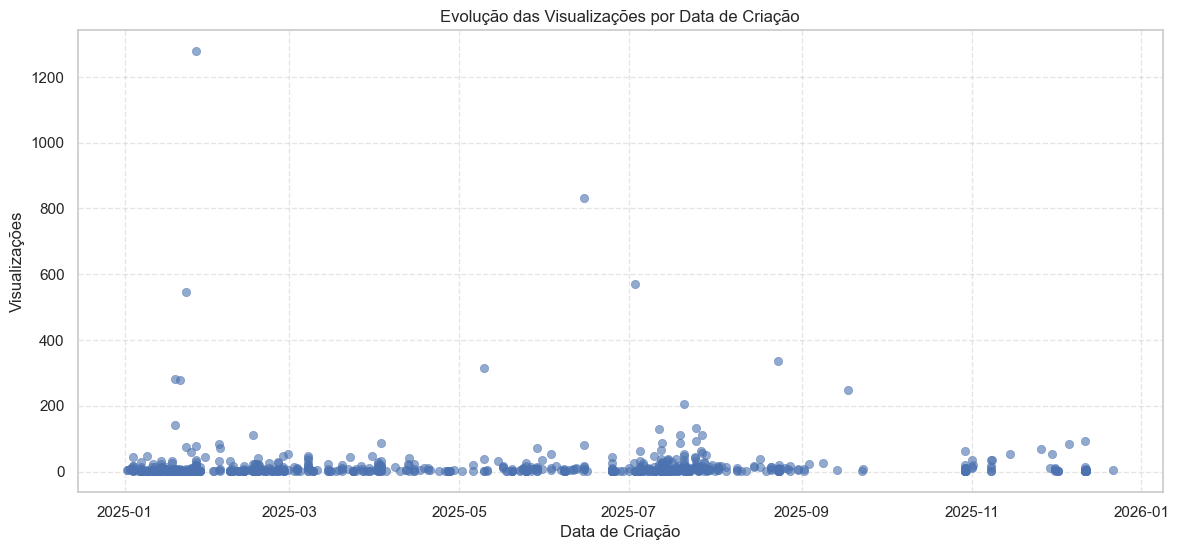

In [10]:
# Acumulado de visualizações por clippers
clipper_views = all_data.groupby('creator_name')['view_count'].sum().sort_values(ascending=False)
print('Acumulado de visualizações por clippers:')
print(clipper_views.head(10))

# Gráfico de evolução das visualizações por clip feito conforme o ano
plt.figure(figsize=(14, 6))
sns.scatterplot(data=all_data, x='created_at', y='view_count', alpha=0.6, edgecolor=None)
plt.title('Evolução das Visualizações por Data de Criação')
plt.xlabel('Data de Criação')
plt.ylabel('Visualizações')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Meses com mais clips:
created_at
July         190
January      182
February      90
March         52
June          46
May           46
August        45
April         43
December      28
October       17
November      13
September      8
Name: count, dtype: int64


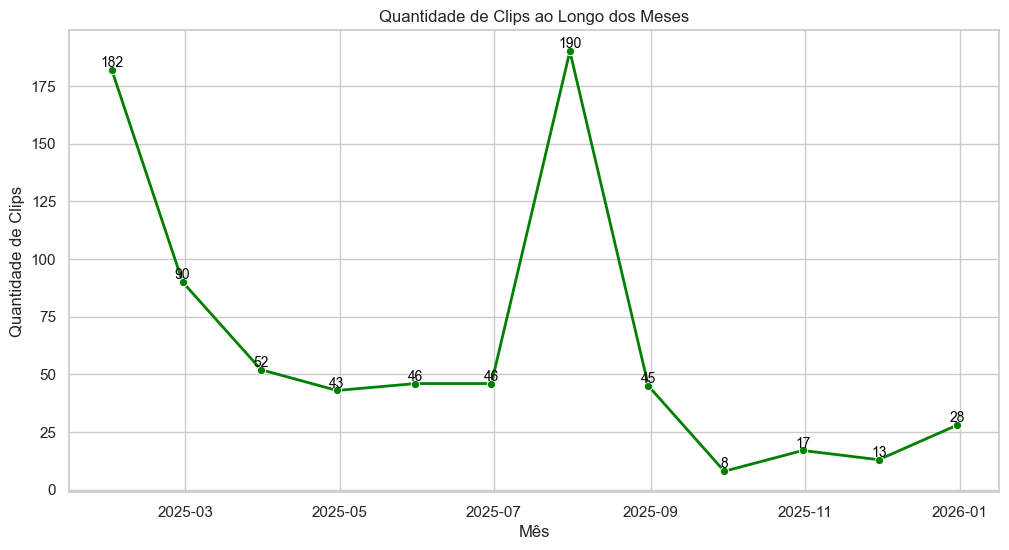

In [32]:
# Meses com mais clips
monthly_clips = all_data['created_at'].dt.month_name().value_counts()
print('Meses com mais clips:')
print(monthly_clips)

# Gráfico comparando a quantidade de clips durante a progressão do ano
monthly_counts = all_data.set_index('created_at').resample('ME').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o', linewidth=2, color='green')
plt.title('Quantidade de Clips ao Longo dos Meses')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Clips')
plt.grid(True)

# Correção aqui: convertendo value para string
for index, value in zip(monthly_counts.index, monthly_counts.values):
    plt.text(index, value, f"{value}", color='black', ha='center', va='bottom', fontsize=10)

plt.show()

In [12]:
# Palavras que mais se repetem nos títulos dos clips
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text


all_titles = ' '.join(all_data['title'].apply(clean_text))
words = all_titles.split()
# Filtrar palavras pequenas ou comuns (stopwords simples)
stopwords = ['a', 'o', 'e', 'de', 'do', 'da', 'em', 'um', 'uma', 'com', 'para', 'que', 'na', 'no', 'se', 'por', 'as', 'os', 'ao', 'aos', 'das', 'dos']
filtered_words = [word for word in words if word not in stopwords and len(word) > 2]

word_counts = Counter(filtered_words)
most_common_20 = word_counts.most_common(20)

print('Palavras que mais se repetem nos títulos:')
for word, count in most_common_20:
    print(f'{count} {word}')


Palavras que mais se repetem nos títulos:
70 eskimo
33 min
23 live
22 dia
18 jogostristes
17 sub
16 real
15 incidentathon
14 bits
14 pix
13 cereaw
12 isso
12 eskimozin
11 ele
11 nao
10 pra
9 mais
9 cara
8 ghile
8 100


Período da Subathon: 2025-07-11 00:00:00-03:00 a 2025-07-31 00:00:00-03:00
Média de views na Subathon: 17.84
Média de views fora da Subathon: 16.00

Maiores clippers na Subathon:
creator_name
rafuxo_2ne1       13
odraudinho        12
kkkkkinho          6
eskimozin          6
engordabucho       6
gabriersdawolf     6
yannn9778          5
littlemots         4
yNettoFPS          4
KyleHunterTTv      4
Name: count, dtype: int64

Maiores clippers fora da Subathon:
creator_name
rafuxo_2ne1           56
eskimozin             39
odraudinho            32
pantaloreza__         21
kkkkkinho             15
Benja_Lenja           14
pestei                14
tinhaqueserotomtom    13
kkjkNick              11
ratoacucar            11
Name: count, dtype: int64

Clips por dia na Subathon: 7.40
Clips por dia fora da Subathon: 1.97
Aumento de 275.05% na produção de clips durante a Subathon.


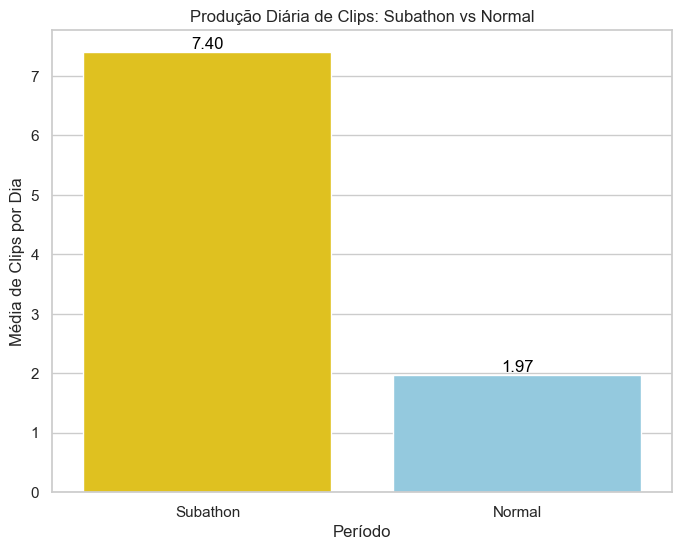

In [20]:
# Sobre os clips feitos durante a Subathon
start_date = pd.Timestamp(STR_SUB_DATE)
end_date = pd.Timestamp(END_SUB_DATE)

print(f'Período da Subathon: {start_date} a {end_date}')

subathon_mask = (all_data['created_at'] >= start_date) & (all_data['created_at'] <= end_date)
subathon_data = all_data[subathon_mask]
normal_data = all_data[~subathon_mask]

# - o quão mais vistos eles são
avg_views_subathon = subathon_data['view_count'].mean()
avg_views_normal = normal_data['view_count'].mean()
print(f'Média de views na Subathon: {avg_views_subathon:.2f}')
print(f'Média de views fora da Subathon: {avg_views_normal:.2f}')

# - quem foram os maiores clippers do período e se são os mesmos fora do período
top_clippers_subathon = subathon_data['creator_name'].value_counts().head(10)
top_clippers_normal = normal_data['creator_name'].value_counts().head(10)

print('\nMaiores clippers na Subathon:')
print(top_clippers_subathon)
print('\nMaiores clippers fora da Subathon:')
print(top_clippers_normal)

# - em quanto aumenta a quantidade de clips feitos em relação aos períodos de live normal
# Normalizando por dia para comparar
days_subathon = (end_date - start_date).days
if days_subathon == 0:
    days_subathon = 1

total_days_range = (all_data['created_at'].max() - all_data['created_at'].min()).days
days_normal = total_days_range - days_subathon

clips_per_day_normal = None
clips_per_day_subathon = None
prod_comparison = None

if days_subathon > 0 and days_normal > 0:
    clips_per_day_subathon = len(subathon_data) / days_subathon
    clips_per_day_normal = len(normal_data) / days_normal
    print(f'\nClips por dia na Subathon: {clips_per_day_subathon:.2f}')
    print(f'Clips por dia fora da Subathon: {clips_per_day_normal:.2f}')
    if clips_per_day_normal > 0:
        increase = ((clips_per_day_subathon - clips_per_day_normal) / clips_per_day_normal) * 100
        print(f'Aumento de {increase:.2f}% na produção de clips durante a Subathon.')

# Gráfico comparando a diferença da produção dos clips (Subathon vs Normal)
prod_comparison = pd.DataFrame({
    'Período': ['Subathon', 'Normal'],
    'Clips por Dia': [clips_per_day_subathon, clips_per_day_normal]
})

plt.figure(figsize=(8, 6))
sns.barplot(data=prod_comparison, x='Período', y='Clips por Dia', palette=['gold', 'skyblue'], hue='Período', legend=False)
plt.title('Produção Diária de Clips: Subathon vs Normal')
plt.ylabel('Média de Clips por Dia')
for index, row in prod_comparison.iterrows():
    plt.text(index, row['Clips por Dia'], f'{row['Clips por Dia']:.2f}', color='black', ha='center', va='bottom')
plt.show()


In [14]:
# Sobre a produção de clips, gerar dados por bi|tri|quad-ri mestre
# Re-amostrando os dados
# '2M' para bimestre, '3M' para trimestre, '4M' para quadrimestre
# Nota: O pandas usa 'ME' para Month End. Para períodos customizados, podemos usar resample.

# Bimestre
bimester_clips = all_data.set_index('created_at').resample('2ME').size()
print('Produção de clips por Bimestre:')
print(bimester_clips)

# Trimestre
trimester_clips = all_data.set_index('created_at').resample('3ME').size()
print('\nProdução de clips por Trimestre:')
print(trimester_clips)

# Quadrimestre
quadrimester_clips = all_data.set_index('created_at').resample('4ME').size()
print('\nProdução de clips por Quadrimestre:')
print(quadrimester_clips)


Produção de clips por Bimestre:
created_at
2025-01-31 00:00:00-03:00    182
2025-03-31 00:00:00-03:00    142
2025-05-31 00:00:00-03:00     89
2025-07-31 00:00:00-03:00    236
2025-09-30 00:00:00-03:00     53
2025-11-30 00:00:00-03:00     30
2026-01-31 00:00:00-03:00     28
dtype: int64

Produção de clips por Trimestre:
created_at
2025-01-31 00:00:00-03:00    182
2025-04-30 00:00:00-03:00    185
2025-07-31 00:00:00-03:00    282
2025-10-31 00:00:00-03:00     70
2026-01-31 00:00:00-03:00     41
dtype: int64

Produção de clips por Quadrimestre:
created_at
2025-01-31 00:00:00-03:00    182
2025-05-31 00:00:00-03:00    231
2025-09-30 00:00:00-03:00    289
2026-01-31 00:00:00-03:00     58
dtype: int64


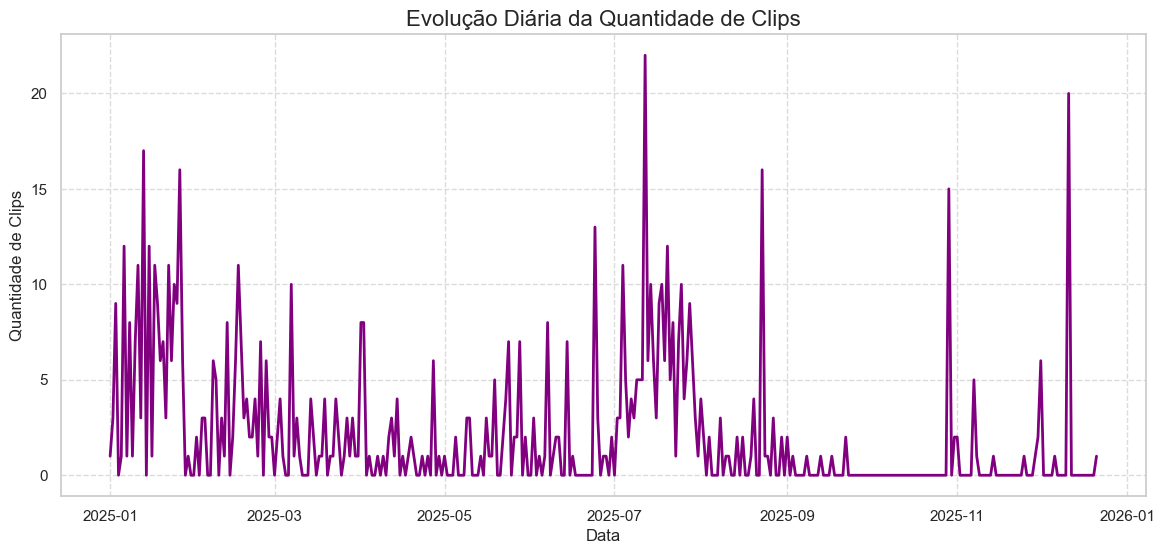

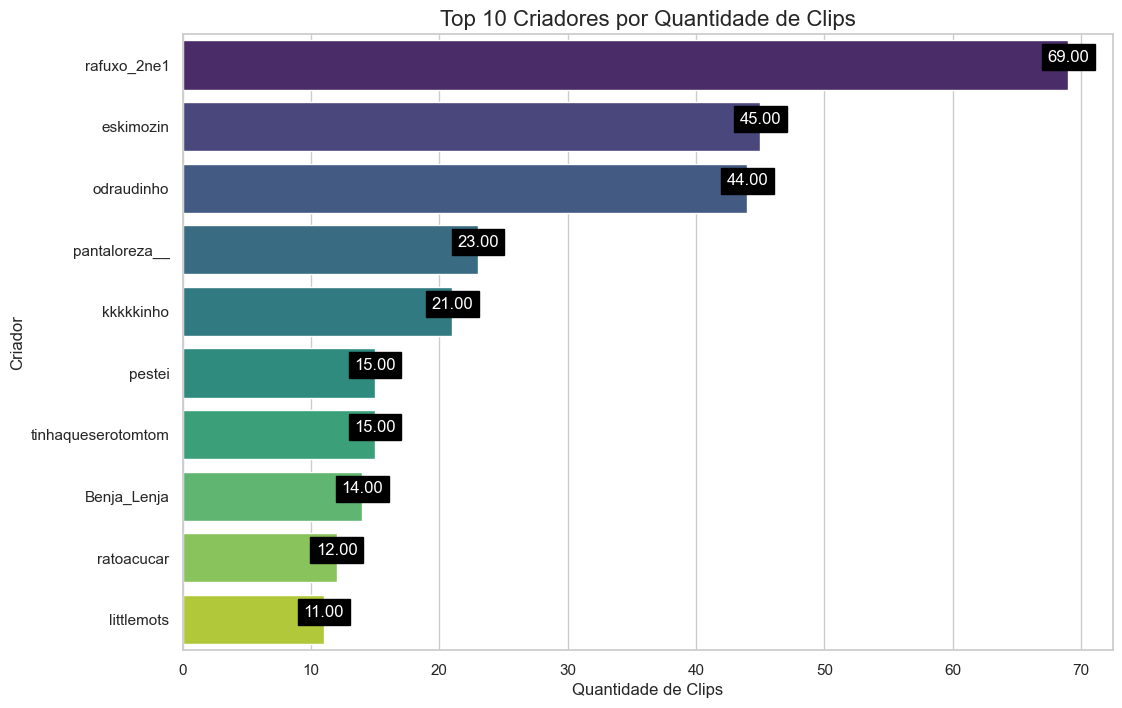

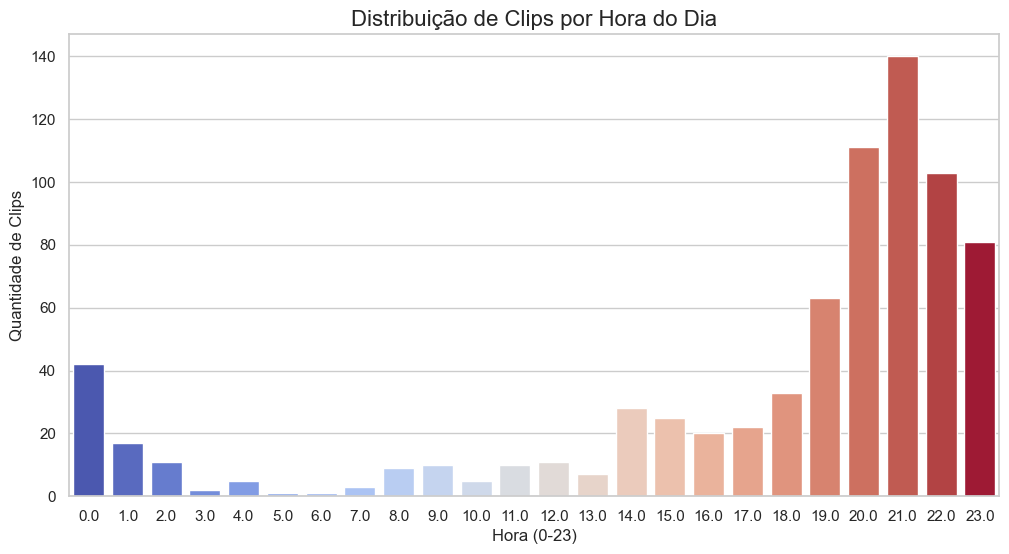

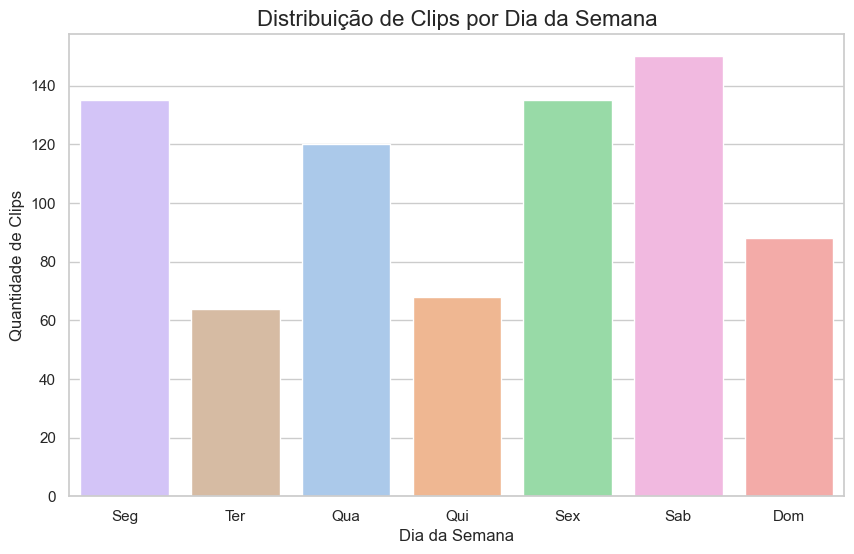

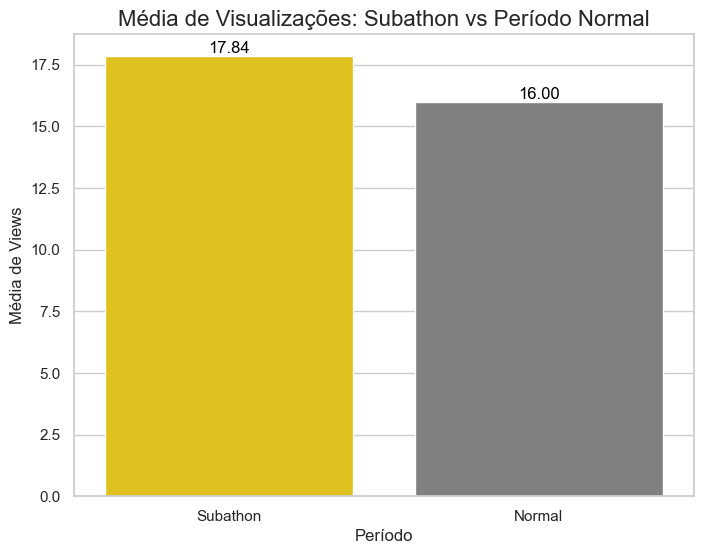

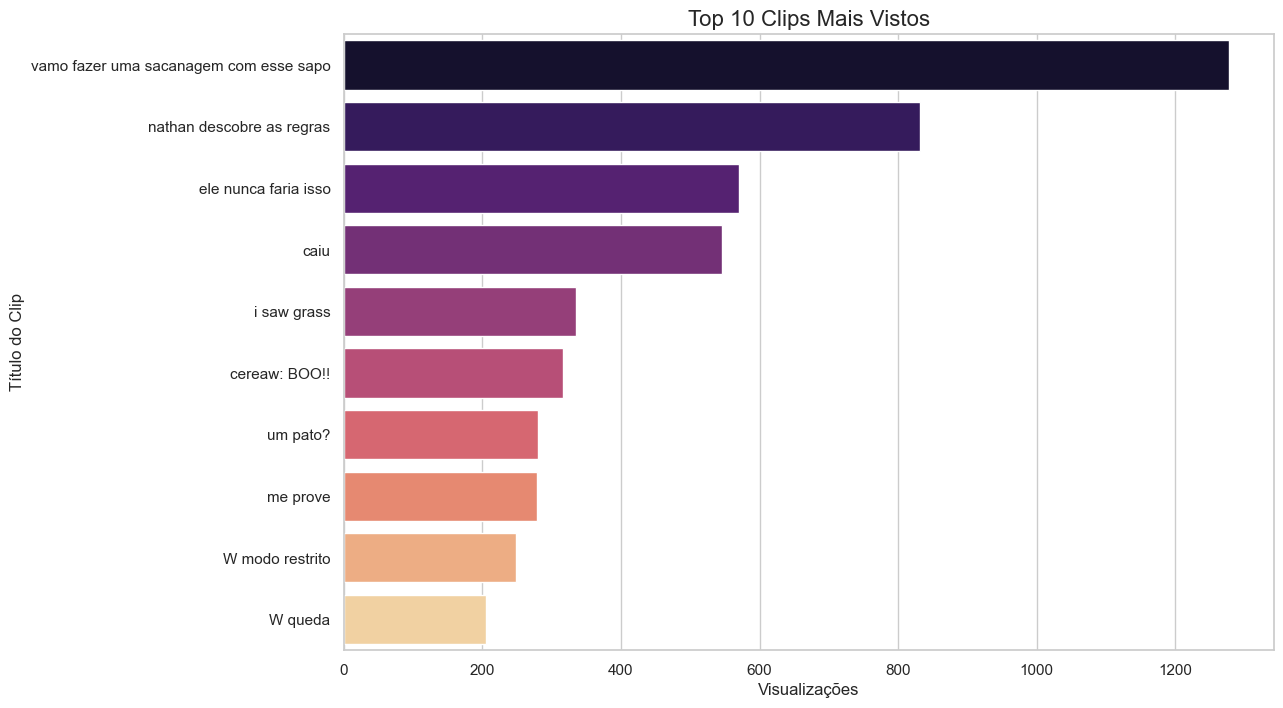

In [34]:
# Evolução Temporal dos Clips (Linha do Tempo)
plt.figure(figsize=(14, 6))
daily_counts = all_data.set_index('created_at').resample('D').size()
sns.lineplot(x=daily_counts.index, y=daily_counts.values, color='purple', linewidth=2)
plt.title('Evolução Diária da Quantidade de Clips', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Quantidade de Clips', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Top 10 Clippers (Quantidade)
plt.figure(figsize=(12, 8))
top_10_creators = all_data['creator_name'].value_counts().head(10)
sns.barplot(x=top_10_creators.values, y=top_10_creators.index, palette='viridis', hue=top_10_creators.index, legend=False)
for value, index in list(zip(top_10_creators.values, top_10_creators.index)):
    plt.text(value, index, f'{value:.2f}', color='white', backgroundcolor='black',  ha='center', va='bottom')
plt.title('Top 10 Criadores por Quantidade de Clips', fontsize=16)
plt.xlabel('Quantidade de Clips', fontsize=12)
plt.ylabel('Criador', fontsize=12)
plt.show()

# Distribuição por Hora do Dia
plt.figure(figsize=(12, 6))
sns.countplot(data=all_data, x='hour', palette='coolwarm', hue='hour', legend=False)
plt.title('Distribuição de Clips por Hora do Dia', fontsize=16)
plt.xlabel('Hora (0-23)', fontsize=12)
plt.ylabel('Quantidade de Clips', fontsize=12)
plt.show()

# Distribuição por Dia da Semana
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_pt = {'Monday': 'Seg', 'Tuesday': 'Ter', 'Wednesday': 'Qua', 'Thursday': 'Qui', 'Friday': 'Sex', 'Saturday': 'Sab', 'Sunday': 'Dom'}
all_data['day_name'] = all_data['created_at'].dt.day_name()

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=all_data, x='day_name', order=days_order, palette='pastel', hue='day_name', legend=False)
ax.set_xticks(range(len(days_order)))
ax.set_xticklabels([days_pt[d] for d in days_order])
plt.title('Distribuição de Clips por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Quantidade de Clips', fontsize=12)
plt.show()

# Comparação Subathon vs Normal (Média de Views)
comparison_df = pd.DataFrame({
    'Período': ['Subathon', 'Normal'],
    'Média de Views': [avg_views_subathon, avg_views_normal]
})

plt.figure(figsize=(8, 6))
sns.barplot(data=comparison_df, x='Período', y='Média de Views', palette=['gold', 'gray'], hue='Período', legend=False)
plt.title('Média de Visualizações: Subathon vs Período Normal', fontsize=16)
plt.ylabel('Média de Views', fontsize=12)
for index, row in comparison_df.iterrows():
    plt.text(index, row['Média de Views'], f'{row['Média de Views']:.2f}', color='black', ha='center', va='bottom')
plt.show()

# Top 10 Clips Mais Vistos (Barra Horizontal)
top_10_viewed = all_data.sort_values(by='view_count', ascending=False).head(10)
# Encurtar títulos longos para o gráfico
top_10_viewed['short_title'] = top_10_viewed['title'].apply(lambda x: x[:40] + '...' if len(x) > 40 else x)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_viewed, x='view_count', y='short_title', palette='magma', hue='short_title', legend=False)
plt.title('Top 10 Clips Mais Vistos', fontsize=16)
plt.xlabel('Visualizações', fontsize=12)
plt.ylabel('Título do Clip', fontsize=12)
plt.show()
